#Previsão de Atrasos de Voos

##Introdução e Objetivos
O objetivo deste projeto é desenvolver um modelo de Machine Learning capaz de prever atrasos e cancelamentos de voos comerciais. Utilizando dados históricos da ANAC, buscamos identificar padrões que antecedem interrupções operacionais.

O problema é tratado como uma tarefa de **Classificação Binária**:
* **Classe 0 (Negativo):** Voo Pontual.
* **Classe 1 (Positivo):** Voo com Atraso ou Cancelado.

Dada a natureza desbalanceada dos dados (a maioria dos voos é pontual), este notebook foca em estratégias de **balanceamento de dados (Undersampling)** e na utilização de algoritmos baseados em árvores (**Random Forest** e **XGBoost**) para maximizar a detecção de atrasos (Recall).



###Importação de Bibliotecas

In [1]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,ConfusionMatrixDisplay, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt


###Conexão com o drive e carregamento do dataset

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Caminho do Arquivo
caminho_arquivo = "/content/drive/MyDrive/Dados_ANAC/dados_limpos_anac.csv"

# Verificação de segurança: O arquivo existe?
if not os.path.exists(caminho_arquivo):
    print(f"ERRO: Arquivo não encontrado em: {caminho_arquivo}")
else:
    print(f"Arquivo encontrado! Tamanho: {os.path.getsize(caminho_arquivo) / (1024*1024):.2f} MB")

    # 3. Carregar o DataFrame
    print("Carregando dados...")
    df = pd.read_csv(caminho_arquivo, sep=';', on_bad_lines='skip', engine='python')

Arquivo encontrado! Tamanho: 125.74 MB
Carregando dados...


### EXTRATOR DE DATAS

Para permitir que o algoritmo identifique padrões temporais, a coluna original de data (`dt_partida_prevista`) foi decomposta. A tabela abaixo resume como a função `ExtratorDeDatas` processa essa informação:

| Dado Original | Nova Feature Gerada | O que ela representa para o modelo? |
| :--- | :--- | :--- |
| `dt_partida_prevista` | **mes_partida** | Identifica a sazonalidade mensal. |
| `dt_partida_prevista` | **dia_semana_partida** | Diferencia dias úteis de finais de semana. |
| `dt_partida_prevista` | **hora_partida** | Captura o horário do voo. Fundamental para identificar congestionamento aéreo nos horários de pico (manhã e fim de tarde). |
| `dt_partida_prevista` | **dia_ano_partida** | Transforma a data em um número de 1 a 365. |

**Por que isso é necessário?**
Algoritmos de Machine Learning matemáticos, como o Random Forest, não "leem" datas no formato calendário (ex: "25/12/2023"). Eles precisam de valores numéricos explícitos. Ao quebrar a data nessas 4 colunas numéricas, transformamos um texto complexo em coordenadas que o modelo consegue correlacionar matematicamente com a probabilidade de um atraso.

In [4]:
class ExtratorDeDatas(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Garante que é uma Series ou pega a primeira coluna do DF
        if isinstance(X_copy, pd.DataFrame):
            series = X_copy.iloc[:, 0]
        else:
            series = X_copy

        # Converte para datetime (se falhar, vira NaT)
        dt_series = pd.to_datetime(series, dayfirst=True, errors='coerce')

        # Retorna DataFrame com as novas features numéricas
        return pd.DataFrame({
            'mes': dt_series.dt.month,
            'dia_semana': dt_series.dt.dayofweek,
            'hora': dt_series.dt.hour,
            'dia_ano': dt_series.dt.day_of_year
        })

    def get_feature_names_out(self, input_features=None):
        return ['mes', 'dia_semana', 'hora', 'dia_ano']

### CONFIGURAÇÃO DAS COLUNAS
O dataset possui variáveis de **alta cardinalidade** (muitas categorias únicas), como:
* Aeroporto de Origem e Destino (`sg_iata_origem/destino`);
* Número do Voo (`nr_voo`);
* Companhia Aérea (`sg_empresa_icao`).



In [5]:
# Numéricas
cols_numericas = ['nr_assentos_ofertados']

# Data
col_data = ['dt_partida_prevista']

# Alta Cardinalidade (Muitas categorias) -> TARGET ENCODER
cols_alta_cardinalidade = [
    'sg_iata_origem',
    'sg_iata_destino',
    'nr_voo',
    'sg_empresa_icao'  ,
    'cd_tipo_linha',
    'sg_equipamento_icao'
]

Utilizar técnicas tradicionais como *One-Hot Encoding* geraria milhares de colunas, aumentando a dimensionalidade e o custo computacional. Optou-se pelo **Target Encoder**, que substitui a categoria pela média da probabilidade de atraso daquela categoria.
*Nota:* O parâmetro `smooth='auto'` foi utilizado para evitar *overfitting* em categorias com poucos registros.

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        # Pipeline da Data
        ('data_proc', ExtratorDeDatas(), col_data),

        #Colunas de Alta Cardinalidade
        ('cat_alta', TargetEncoder(target_type='binary', smooth='auto'), cols_alta_cardinalidade),

        # Numéricas passam direto
        ('num', 'passthrough', cols_numericas)
    ],
    verbose_feature_names_out=False
)

## Estrutura e modelo do treinamento
A etapa final do pipeline consiste no classificador. O algoritmo escolhido foi o **Random Forest Classifier**, um método de *ensemble* baseado em árvores de decisão.
### Configuração do modelo
O modelo utilizado foi o random forest, com pessos balanceados, tendo em vista que existem muito mais voos que não atrasam do que o contrario, também foi utlizado processamento paralelo para agilizar o processo de treinamento
### Estrategia do modelo
1.  **Divisão dos Dados:** O dataset foi separado em Treino (70%) e Teste (30%).
2.  **Undersampling:** Nos dados de **treino apenas**, foi aplicado o `RandomUnderSampler`. Isso reduz a quantidade de voos pontuais para igualar a quantidade de voos atrasados, permitindo que o modelo aprenda os padrões de atraso sem ser enviesado pela maioria pontual.
3.  **Ajuste de Hiperparâmetros:** Foi utilizado o `RandomizedSearchCV` para testar diferentes combinações de profundidade da árvore e número de estimadores, buscando maximizar a métrica **F1-Score**.
###Consolidação do Modelo Final

Com os melhores hiperparâmetros identificados, o pipeline foi re-instanciado para o treinamento definitivo.

A configuração final do **Random Forest** combina a robustez do balanceamento de classes com a profundidade otimizada encontrada na etapa de busca:

* **Parâmetros de Estrutura:** `n_estimators=100`, `max_depth=20`.
* **Parâmetros de Generalização:** `min_samples_split=5`, `min_samples_leaf=4`.
* **Parâmetros de Negócio:** `class_weight='balanced'` (para priorizar a detecção de atrasos).

Este modelo consolidado é o que segue para a etapa de validação nos dados de teste (que foram mantidos isolados até este momento).

In [7]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('modelo', RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=4,
        criterion='gini',
        class_weight='balanced',
        verbose=1,
        random_state=42,
        n_jobs=-1
    ))
])

## Execução Simulada e Avaliação Detalhada
Após o treinamento do modelo otimizado, realizamos a avaliação final utilizando o conjunto de dados de teste (30% do total), que foi mantido isolado durante todo o processo para garantir a isenção dos resultados.

In [10]:
#Separação do target
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#undersampling
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)

print("Treinando Pipeline...")
pipeline.fit(X_train_res, y_train_res)



Treinando Pipeline...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('data_proc',
                                                  ExtratorDeDatas(),
                                                  ['dt_partida_prevista']),
                                                 ('cat_alta',
                                                  TargetEncoder(target_type='binary'),
                                                  ['sg_iata_origem',
                                                   'sg_iata_destino', 'nr_voo',
                                                   'sg_empresa_icao',
                                                   'cd_tipo_linha',
                                                   'sg_equipamento_icao']),
                                                 ('num', 'passthrough',
                                                  ['nr_assentos_ofertados'])],
                                   verbose_feature_names_out=False)),
                ('modelo',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        min_samples_leaf=4, min_samples_split=5,
                                        n_jobs=-1, random_state=42,
                                        verbose=1))])


--- Avaliação do Desempenho ---


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.8s finished


Acurácia:  0.7028
Precisão:  0.1766
Recall:    0.6192
F1-Score:  0.2748

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.95      0.71      0.81    769098
           1       0.18      0.62      0.27     76938

    accuracy                           0.70    846036
   macro avg       0.56      0.67      0.54    846036
weighted avg       0.88      0.70      0.76    846036


--- Exemplo de Previsão com Probabilidade ---
          Voo        Predição  Probabilidade Atraso (%)
1778651  0273      Atraso (1)                     87.84
1475395  9520      Atraso (1)                     78.72
1164990  0781  No Horário (0)                     35.01
980062   2601  No Horário (0)                     45.66
1302592  1026  No Horário (0)                     25.56


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


<Figure size 800x600 with 0 Axes>

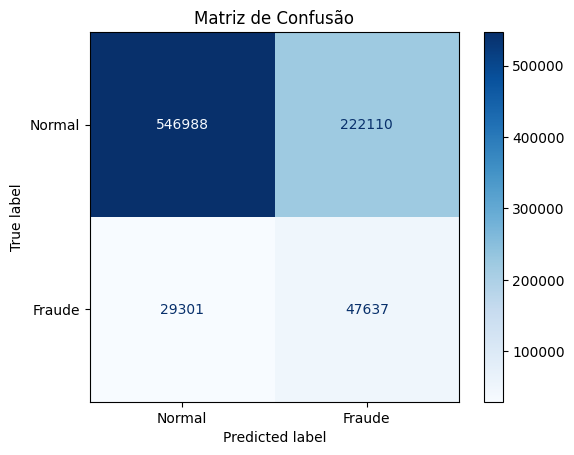

In [11]:
print("\n--- Avaliação do Desempenho ---")
y_pred = pipeline.predict(X_test)

# Métricas principais
print(f"Acurácia:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisão:  {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")

# Relatório completo (opcional)
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

print("\n--- Exemplo de Previsão com Probabilidade ---")
# Pegando 5 exemplos do teste para demonstrar
novos_voos = X_test.iloc[0:5].copy()

# Prevê a classe (0 ou 1)
previsao_classe = pipeline.predict(novos_voos)

# Prevê a probabilidade (retorna array com [prob_0, prob_1])
# Pegamos apenas a coluna 1, que é a probabilidade de atraso
previsao_prob = pipeline.predict_proba(novos_voos)[:, 1]

# Exibindo de forma legível
resultados = pd.DataFrame({
    'Voo': novos_voos['nr_voo'] if 'nr_voo' in novos_voos.columns else range(len(novos_voos)),
    'Predição': ['Atraso (1)' if p == 1 else 'No Horário (0)' for p in previsao_classe],
    'Probabilidade Atraso (%)': (previsao_prob * 100).round(2)
})
print(resultados)

# 4. Matriz de Confusão Visual
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraude'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusão')
plt.show()

In [12]:
print(pipeline.named_steps.keys())

dict_keys(['preprocessor', 'modelo'])


In [13]:
print("\n--- Importância das Features ---")

# Obter o modelo RandomForestClassifier do pipeline
modelo_rf = pipeline.named_steps['modelo']

# Obter os nomes das features após o pré-processamento
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Obter as importâncias das features
importancias = modelo_rf.feature_importances_

# Criar um DataFrame para melhor visualização
df_importancias = pd.DataFrame({
    'Feature': feature_names,
    'Importancia': importancias
})

# Ordenar por importância e exibir
df_importancias = df_importancias.sort_values(by='Importancia', ascending=False)
print(df_importancias)


--- Importância das Features ---
                  Feature  Importancia
6                  nr_voo     0.207477
3                 dia_ano     0.149339
4          sg_iata_origem     0.095879
7         sg_empresa_icao     0.095537
2                    hora     0.092687
5         sg_iata_destino     0.090026
9     sg_equipamento_icao     0.086099
1              dia_semana     0.057545
0                     mes     0.042731
10  nr_assentos_ofertados     0.041653
8           cd_tipo_linha     0.041028


## Persistência e Exportação do Modelo
Para que o modelo possa ser utilizado em produção, é necessário exportá-lo do ambiente de desenvolvimento.

O objeto `pipeline` treinado foi serializado e salvo com o nome **`modelo_atraso_voos_rf_res.pkl`**.

> **Nota de Arquitetura:**
> Ao salvar o objeto `pipeline` completo, garantimos que a aplicação final não precisa reescrever o código de limpeza. O arquivo `.pkl` contém:
> 1.  A lógica da classe customizada `ExtratorDeDatas`.
> 2.  As médias aprendidas pelo `TargetEncoder` para aeroportos e empresas.
> 3.  Os pesos e a estrutura da `RandomForest` otimizada.
>
> Isso assegura que qualquer novo dado inserido na aplicação passará exatamente pelo mesmo tratamento matemático que os dados de treino, garantindo a validade da previsão.

In [15]:
print("\n--- Salvando o Modelo ---")

# Caminho onde deseja salvar.
caminho_pasta = '/content/drive/MyDrive/Dados_ANAC/Modelos'

# Cria a pasta se ela não existir
if not os.path.exists(caminho_pasta):
    os.makedirs(caminho_pasta)

nome_arquivo = 'modelo_atraso_voos_rf_res.pkl'
caminho_completo = os.path.join(caminho_pasta, nome_arquivo)

# Salva o objeto do pipeline (que contém o pré-processamento e o modelo treinado)
joblib.dump(pipeline, caminho_completo)

print(f"Modelo salvo com sucesso em: {caminho_completo}")
print(f"Para carregar use: modelo_carregado = joblib.load('{caminho_completo}')")


--- Salvando o Modelo ---
Modelo salvo com sucesso em: /content/drive/MyDrive/Dados_ANAC/Modelos/modelo_atraso_voos_rf_res.pkl
Para carregar use: modelo_carregado = joblib.load('/content/drive/MyDrive/Dados_ANAC/Modelos/modelo_atraso_voos_rf_res.pkl')


## Conclusão e Desafios de Evolução

O projeto entregou um modelo funcional de **Random Forest** capaz de identificar preventivamente cerca de **63% dos voos que sofrerão atraso**, servindo como uma ferramenta eficaz de triagem de risco.

No entanto, a análise dos resultados revelou barreiras significativas para aumentar a precisão (atualmente em ~18%) e a assertividade geral. As principais dificuldades encontradas foram:

### A Limitação dos Dados Estáticos vs. Dinâmicos
A maior dificuldade para melhorar o modelo reside na natureza dos dados da ANAC. Sem a ingestão de dados em tempo real (APIs de clima ou status de tráfego aéreo), o modelo atinge um "teto de vidro" de performance, pois tenta prever eventos caóticos usando apenas o calendário.

### O Trade-off Precisão/Recall
Para capturar a maioria dos atrasos (Recall alto), o modelo precisou ser configurado como "sensível". Tentar limpar os Falsos Positivos (aumentar a Precisão) resultou, nos testes, em uma queda drástica na detecção dos atrasos reais.
**Conclusão Técnica:** Com as features atuais, o modelo não consegue distinguir matematicamente um voo que atrasa por "tráfego aéreo" de um voo idêntico (mesma hora/rota) que sai pontual. A distinção reside em variáveis ocultas (ex: clima) que o modelo não possui.

---
**Veredito Final:** O modelo é robusto para **alertar riscos baseados em sazonalidade e rotas problemáticas**, mas para evoluir para um assistente em tempo real de alta precisão, seria indispensável o enriquecimento dos dados com fontes externas de meteorologia.